In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

In [2]:
idxmap=pd.read_csv("../input/train_3.csv",usecols=["Page"])['Page'].to_dict()

In [3]:
keys=pd.read_csv("../input/key_2.csv",index_col=0)
keys_dict=keys["Id"].to_dict()
len(keys_dict)

8993906

# make submission

In [70]:
pred=pd.read_csv("../input/spark2_pred_log_mix3_xgb.csv",header=None)

In [71]:
date_cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 9, 11)), periods=63).map(lambda u: u.strftime("%Y-%m-%d")).tolist()
pred.columns=['ppage','Date']+date_cols

In [72]:
pred=pred.drop(['2017-09-11','2017-09-12'],axis=1)
pred.shape

(145063, 63)

In [73]:
pred['2017-11-13']=pred['2017-11-12'].copy()

In [74]:
pred.head()

ppage  Date  2017-09-13  2017-09-14  2017-09-15  2017-09-16  2017-09-17  \
0  p100083    99    5.882110    5.845192    5.854689    5.901788    5.960352   
1  p100274    99    6.929013    6.935893    6.896738    6.904897    7.128407   
2  p100284    99    6.059290    6.108708    6.017485    5.850340    5.916959   
3  p100535    99    6.287234    6.277630    6.283429    6.291317    6.318589   
4  p100614    99    7.489683    7.523804    7.458891    7.436610    7.522440   

   2017-09-18  2017-09-19  2017-09-20     ...      2017-11-04  2017-11-05  \
0    5.815174    5.814718    5.767387     ...        5.637989    5.714660   
1    6.916246    6.910259    6.932567     ...        6.989763    7.099834   
2    6.048887    6.050232    6.113092     ...        5.918953    5.967192   
3    6.448533    6.379728    6.324652     ...        6.341909    6.392903   
4    7.473498    7.350741    7.347087     ...        7.086192    7.111718   

   2017-11-06  2017-11-07  2017-11-08  2017-11-09  2017-11-10  2017-11-11  \
0    5.658036    5.650600    5.524096    5.393836    5.568985    5.640888   
1    7.141192    7.056274    7.028537    6.999223    7.010233    7.017515   
2    6.126689    6.141469    6.124546    6.098928    5.903122    5.816311   
3    6.522948    6.535208    6.487682    6.467141    6.362493    6.256393   
4    7.140798    7.035421    7.029770    7.025640    7.041246    7.092812   

   2017-11-12  2017-11-13  
0    5.783194    5.783194  
1    7.123739    7.123739  
2    5.846907    5.846907  
3    6.361799    6.361799  
4    7.135798    7.135798  

[5 rows x 64 columns]

In [75]:
pred['pageidx']=pred.ppage.map(lambda u: int(u[1:]))

In [76]:
pred=pred.sort_values("pageidx")

In [77]:
newdate_cols=date_cols[2:]+['2017-11-13']

In [78]:
for col in newdate_cols:
    pred[col]=np.exp(pred[col]) 

In [79]:
pred['page']=pred['pageidx'].map(lambda u: idxmap[u])

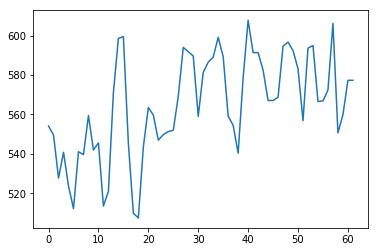

In [80]:
plt.plot(pred.loc[int(np.random.random()*pred.shape[0]),newdate_cols].values);

In [81]:
pred.index=pred['pageidx']

In [82]:
submission=pred.drop(['ppage','Date','pageidx','page'],axis=1)

In [83]:
submission=submission.unstack().reset_index()


In [84]:
submission['page']=submission['pageidx'].map(lambda u: idxmap[u])

In [85]:
submission['Id']=submission[['page','level_0']].apply(lambda u: "{}_{}".format(u.values[0],u.values[1]),axis=1)

In [86]:
submission=submission[['Id',0]]

In [87]:
submission["Id"]=submission["Id"].apply(lambda u:keys_dict[u])

In [88]:
submission.isnull().sum().sum()

0

In [89]:
newsubmission=submission
newsubmission.index=newsubmission['Id']
newsubmission=newsubmission.drop("Id",axis=1)

In [90]:
newsubmission.columns=['Visits']

In [91]:
(newsubmission.Visits<0.5).mean(),(newsubmission.Visits<0).mean()

(0.0, 0.0)

In [92]:
newsubmission.shape

(8993906, 1)

In [93]:
newsubmission.head()

Visits
Id                     
4ba4d551a031  24.145857
60d27ad56a15  21.622460
fd318ba35812   5.389103
6f94c9eff16b  15.005746
3d831f757952  12.910114

In [94]:
newsubmission.to_csv("../submission/sub2_pred_xgb_log_mix3.csv.gz",
                                    float_format='%.1f', compression="gzip")

In [95]:
a=pd.concat([pd.read_csv("../submission/sub2_pred_xgb_log_mix1.csv.gz",index_col=0),
            pd.read_csv("../submission/sub2_pred_xgb_log_mix2.csv.gz",index_col=0),
            pd.read_csv("../submission/sub2_pred_xgb_log_mix3.csv.gz",index_col=0)],axis=1)

In [96]:
a.head()

Visits  Visits  Visits
Id                                  
4ba4d551a031    21.8    25.8    24.1
60d27ad56a15    23.9    21.7    21.6
fd318ba35812     4.6     6.8     5.4
6f94c9eff16b    17.0    15.7    15.0
3d831f757952    16.1    14.9    12.9

In [98]:
b=pd.DataFrame(a.mean(1),columns=['Visits'])

In [99]:
b.head()

Visits
Id                     
4ba4d551a031  23.900000
60d27ad56a15  22.400000
fd318ba35812   5.600000
6f94c9eff16b  15.900000
3d831f757952  14.633333

In [100]:
b.to_csv("../submission/sub2_pred_xgb_log_mix123.csv.gz",
                                    float_format='%.1f', compression="gzip")